In [1]:
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import joblib
from pandarallel import pandarallel
from tqdm import tqdm 
import re

from numpy import genfromtxt
from pdga.sequence import smiles_from_seq

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

from mxfp.mxfp import MXFPCalculator
from faerun import Faerun
from sklearn.decomposition import PCA

np.random.seed(42)
pandarallel.initialize(progress_bar=True)
tqdm.pandas()

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Import dendrimer library and lists of previously synthesized compound. Define sequences of important selected compounds (G3KL, T7, T25, XG45, XG60)

In [2]:
data = joblib.load("data/50k_MAP4.pkl")

synth_2021_64 = pd.read_excel("data/64_2021.xlsx", header=None, engine='openpyxl')
synth_2021_64.columns=["name", "seq"]
synth_2021 = synth_2021_64.seq.to_list()

synth_2018_39 = pd.read_excel("data/39_2018.xlsx", header=None, engine='openpyxl')
synth_2018_39.columns=["name", "seq"]

synth_2018 = synth_2018_39.seq.to_list()

G3KL = "(KL)8(KKL)4(KKL)2KKL"
T7 = "(KL)8(KKL)4(KKLL)2KKKL"
T25 = "(KL)8(KKL)4(KLL)2KKLL"
XG45 ="(KL)8(KLK)4(KLL)2KLLL"
XG60 ="(KL)8(KL)4(KKLL)2KLKK"

Define function to fix MXFP fingerprint after importing from pickle

In [3]:
def FixMXFP(mxfp):
    str_list = mxfp.split(';')
    return [int(s) for s in str_list]

Create pandas dataframe from dendrimer library

In [4]:
tuple_list = data['SMILES'].values.tolist()
df = pd.DataFrame(tuple_list, columns=['SMILES', 'seq'])
df['MXFP'] = data['MXFP'].values.tolist()
df['MXFP'] = df['MXFP'].apply(FixMXFP)
df['seq'] = data['seq'].values.tolist()
df['seq2'] = data['seq2'].values.tolist()
df['seq3'] = data['seq3'].values.tolist()

Calculate properties (from Alice's notebook)

In [5]:
def MW(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mw = rdMolDescriptors.CalcExactMolWt(mol)
    return round(mw,2)

def num_K(seq):
    k= 0
    gens = seq.split('B')[::-1]
    for i, gen in enumerate(gens):
        j = 0
        if i == 0:
            j = 1
        else:
            j = 2**i
        k += (gen.count('K'))*j
    return k

def num_L(seq):
    l = 0
    gens = seq.split('B')[::-1]
    for i, gen in enumerate(gens):
        j = 0
        if i == 0:
            j = 1
        else:
            j = 2**i
        l += (gen.count('L'))*j
    return l

def length(seq):
    return num_K(seq) + num_L(seq)

def frac_K(seq):
    return num_K(seq)/(num_K(seq) + num_L(seq))

def frac_L(seq):
    return num_L(seq)/(num_K(seq) + num_L(seq))

def VarPos(seq2):
    gen_count = seq2.count('B')
    if gen_count == 3:
        return num_K(seq2) + num_L(seq2) - 14
    elif gen_count == 2:
        return num_K(seq2) + num_L(seq2) - 6
    elif gen_count == 1:
        return num_K(seq2) + num_L(seq2) - 2
    else:
        return num_K(seq2) + num_L(seq2)

def VarPos_G0(seq2):
    subseq = re.split(r'B', seq2)
    return len(subseq[-1])

def VarPos_G1(seq2):
    subseq = re.split(r'B', seq2)
    if len(subseq) <= 1:
        return 0
    else:
        return len(subseq[-2])

def VarPos_G2(seq2):
    subseq = re.split(r'B', seq2)
    if len(subseq) <= 2:
        return 0
    else:
        return len(subseq[-3])

def VarPos_G3(seq2):
    subseq = re.split(r'B', seq2)
    if len(subseq) <= 3:
        return 0
    else:
        return len(subseq[-4])

mxfp_query = "5;5;7;8;9;10;11;13;17;21;27;36;44;52;64;82;100;111;104;92;61;14;0;0;0;0;0;0;0;0;0;7;5;5;4;3;4;8;10;13;16;18;26;34;41;47;62;77;86;82;72;50;12;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;16;0;0;0;0;10;1;3;8;7;12;14;15;18;24;31;37;40;34;27;14;1;0;0;0;0;0;0;0;0;0;13;0;0;8;0;1;9;4;6;9;10;12;17;21;25;31;39;44;44;43;33;10;0;0;0;0;0;0;0;0;0;21;0;0;0;0;1;6;0;0;0;0;2;5;11;11;7;11;23;29;30;46;29;2;0;0;0;0;0;0;0;0;100;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0"
b = np.array(list(map(int, mxfp_query.split(';'))))
def calc_CBD(mxfp):
    a = np.array(mxfp)
    return sum(abs(a-b))

In [6]:
df['MW'] = df.SMILES.progress_apply(MW)
df['num_K'] = df.seq2.progress_apply(num_K)
df['num_L'] = df.seq2.progress_apply(num_L)
df['frac_K'] = df.seq2.progress_apply(frac_K)
df['frac_L'] = df.seq2.progress_apply(frac_L)
df['NumVarPos'] = df.seq2.progress_apply(VarPos)
df['VarPos_G0'] = df.seq2.progress_apply(VarPos_G0)
df['VarPos_G1'] = df.seq2.progress_apply(VarPos_G1)
df['VarPos_G2'] = df.seq2.progress_apply(VarPos_G2)
df['VarPos_G3'] = df.seq2.progress_apply(VarPos_G3)
df['CBD'] = df.MXFP.progress_apply(calc_CBD)

100%|██████████| 50625/50625 [00:01<00:00, 38391.27it/s]


Extract CBD of 64 compounds synthesized in 2021 towards T25

In [7]:
def CalcSeq2(sequence):
    return sequence.replace("(", "").replace(")","").replace("8K","B").replace("4K","B").replace("2K","B")

def CalcSeq3(sequence):
    return sequence.replace("(", "").replace("B","4")

def CalcCBD(mxfp, query):
    return sum(abs(np.array(mxfp)-np.array(query)))

MXFP = MXFPCalculator()
def calc_mxfp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mxfp = MXFP.calc_mxfp(mol)
    return np.array(mxfp)

T25_SMILES = 'CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCNC(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCNC(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCNC(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCNC(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)CCCCN)C(=O)O'
T25_MXFP = calc_mxfp(T25_SMILES)

synth_2021_64['seq2'] = synth_2021_64.seq.apply(CalcSeq2)
synth_2021_64['seq3'] = synth_2021_64.seq2.apply(CalcSeq3)
synth_2021_64['SMILES_Sequence'] = synth_2021_64.seq3.apply(smiles_from_seq)
synth_2021_64['SMILES'] = synth_2021_64.SMILES_Sequence.apply(lambda x: x[0])
synth_2021_64['MXFP'] = synth_2021_64.SMILES.progress_apply(calc_mxfp)
synth_2021_64['CBD'] = synth_2021_64.MXFP.apply(lambda x: CalcCBD(x, T25_MXFP))

100%|██████████| 64/64 [00:12<00:00,  5.06it/s]


In [8]:
synth_2021_64.to_csv('data/CBD_64.csv')

Properties for plotting with Faerun

In [38]:
def isSelected(row):
    if row.seq == XG60:
        return '6 - XG60'
    elif row.seq == XG45:
        return '5 - XG45'
    elif row.seq == T25:
        return '4 - T25'
    elif row.seq == T7:
        return '3 - T7'
    elif row.seq == G3KL:
        return '2 - G3KL'
    elif row.seq in synth_2021:
        return '1 - Synthesized'
    else:
        return '0 - Not synthesized'
    
def calc_size(seq):
    if seq == G3KL or seq == T25 or seq==T7 or seq ==XG45 or seq == XG60:
        return 2
    elif seq in synth_2021:
        return 1
    else:
        return 0.5

In [40]:
df['Set'] = df.apply(isSelected, 1)
df['Size'] = df.seq.map(calc_size)
size_list = df['Size'].values.tolist()

#### Violin plots of distribution of num_K and num_L

In [11]:
K_list = df['num_K'].values.tolist()
L_list = df['num_L'].values.tolist()
violin_list = K_list + L_list

set = []
for i in range(0, len(K_list)):
    set.append('num_K')
for i in range(len(L_list), len(violin_list)):
    set.append('num_L')

df_violin = pd.DataFrame({'count': violin_list, 'set': set})
df_violin['label'] = 'library'

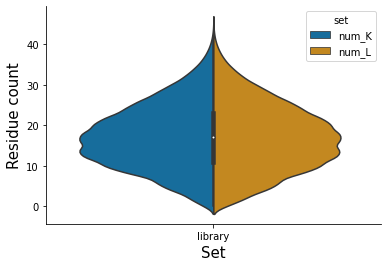

In [12]:
import seaborn as sns

ax = sns.violinplot(x='label', y='count', data=df_violin, palette='colorblind', hue='set', split=True)
ax.set_xlabel('Set', fontsize = 15)
ax.set_ylabel('Residue count', fontsize = 15)
sns.set(font_scale = 1.5)
sns.set_style('ticks')
sns.despine()

plt.savefig('plots/numKL_violin.pdf', bbox_inches='tight')

#### Faerun plots

Reorder dataframe so important compounds are on top

In [13]:
df = df.sort_values(by='Set')

Prepare labels and colormaps

In [41]:
labels = []
for i, row in df.iterrows():
    labels.append(
            row["SMILES"]
            + "__"
            + f'{row["seq"]}'
        )

set_labels, set_data = Faerun.create_categories(df['Set'])
g0_labels, g0_data = Faerun.create_categories(df['VarPos_G0'])
g1_labels, g1_data = Faerun.create_categories(df['VarPos_G1'])
g2_labels, g2_data = Faerun.create_categories(df['VarPos_G2'])
g3_labels, g3_data = Faerun.create_categories(df['VarPos_G3'])

seven_cmap = ListedColormap(["#E0E0E0", '#0F5796', '#D81B60', '#71CDEF', '#04C73B', '#D81BCA', '#FFC107'], name="custom_8")
five_cmap = ListedColormap([ "#D81B60", '#1E88E5', '#FFC107', '#004D40', '#76E84E'], name="custom_5")

#### PCA with MXFP fingerprint

In [15]:
pca2D = PCA(n_components=2)
pca3D = PCA(n_components=3)

PCA 2D

In [16]:
mxfp = df['MXFP'].values.tolist()
pca_mxfp_2D = pca2D.fit_transform(mxfp)
pca2D.explained_variance_ratio_

array([0.71121053, 0.15715385])

Static PCA plot

In [17]:
df['PC1'] = pca_mxfp_2D[:, 0]
df['PC2'] = pca_mxfp_2D[:, 1]

In [18]:
sns.set(rc={'figure.figsize':(18, 12)})

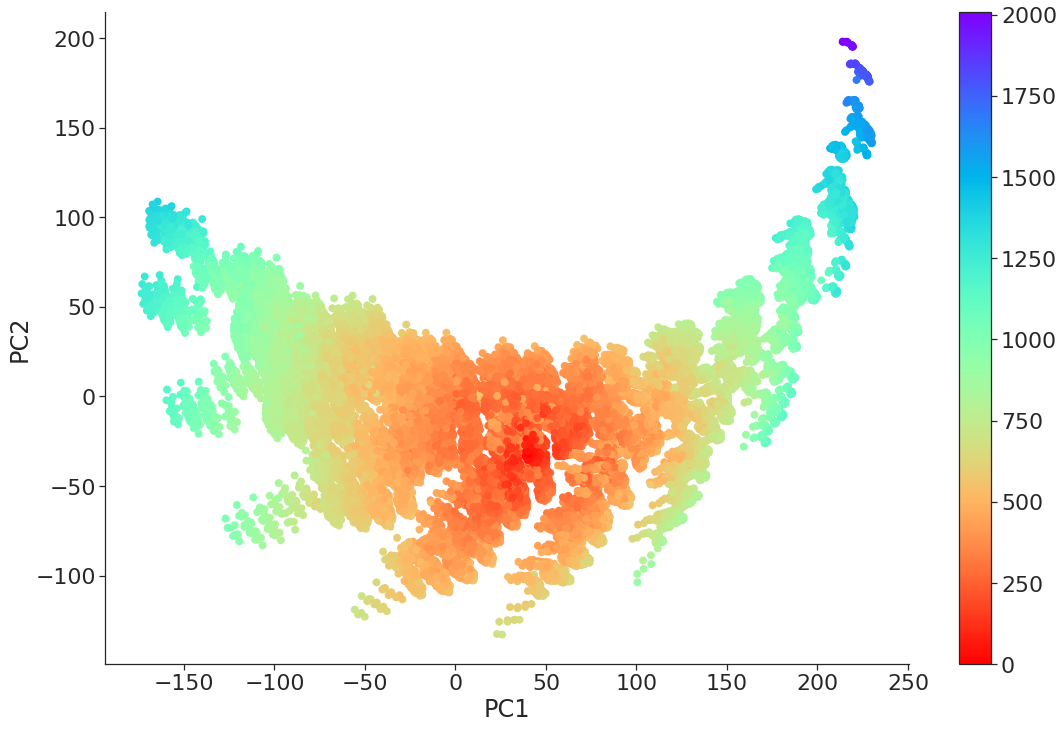

In [21]:
ax = sns.scatterplot(x='PC1', y='PC2', data=df, palette='rainbow_r', hue='CBD', marker='.', s=250, linewidth=0)

norm = plt.Normalize(df['CBD'].min(), df['CBD'].max())
sm = plt.cm.ScalarMappable(cmap="rainbow_r", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm)

sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()

plt.savefig('plots/T25_MXFP_PCA_2D_static.pdf', bbox_inches='tight')

Static plot zoom in

In [22]:
df_zoom = df[(df['PC1'].between(0, 60)) & (df['PC2'].between(-60, 0))]

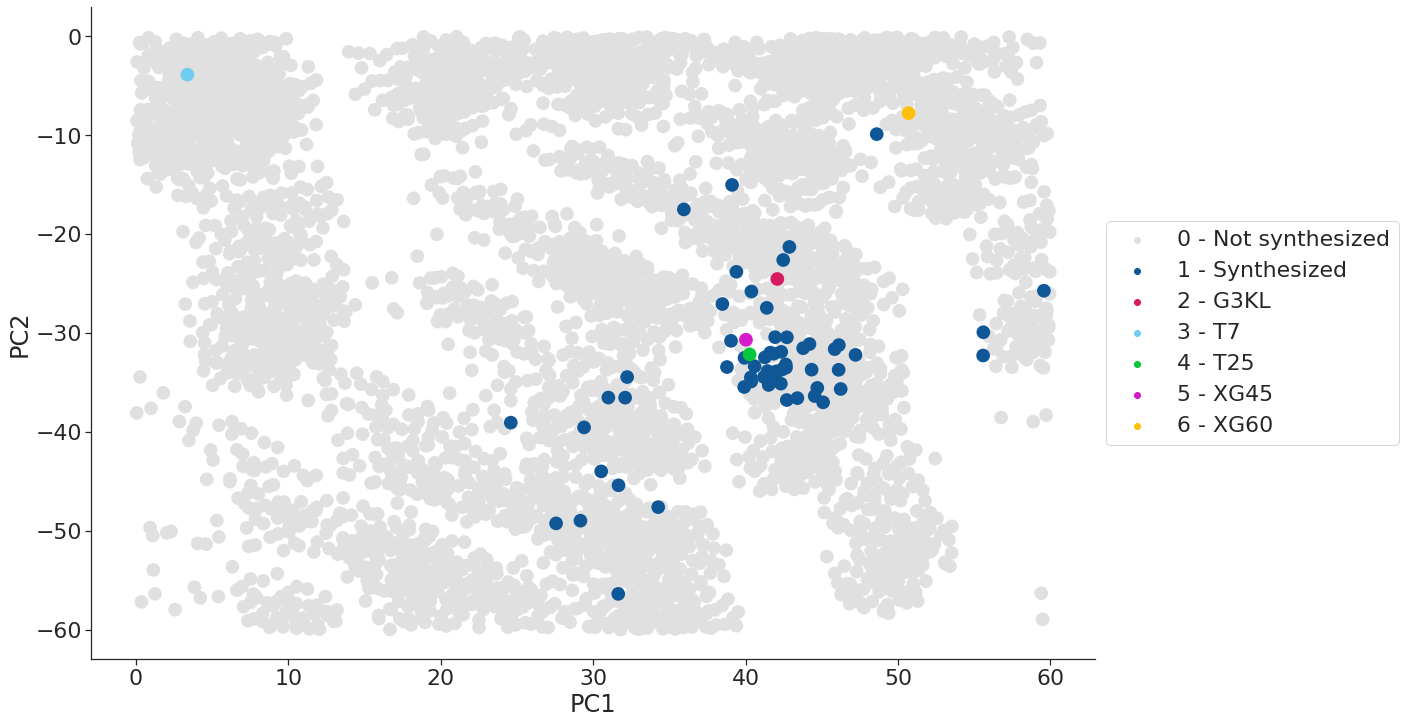

In [23]:
ax = sns.scatterplot(x='PC1', y='PC2', data=df_zoom, palette=["#E0E0E0", '#0F5796', '#D81B60', '#71CDEF', '#04C73B', '#D81BCA', '#FFC107'], hue='Set', marker='.', s=750, linewidth=0)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()

plt.savefig('plots/T25_MXFP_PCA_2D_static_zoom.pdf', bbox_inches='tight')

#### Scatter plots

In [24]:
df_scatter = df[df['Set'] != '0 - Not synthesized']
df_scatter['Length'] = df_scatter.seq2.apply(length)

/home/markus/miniconda3/envs/chemical_space/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Length vs. CBD

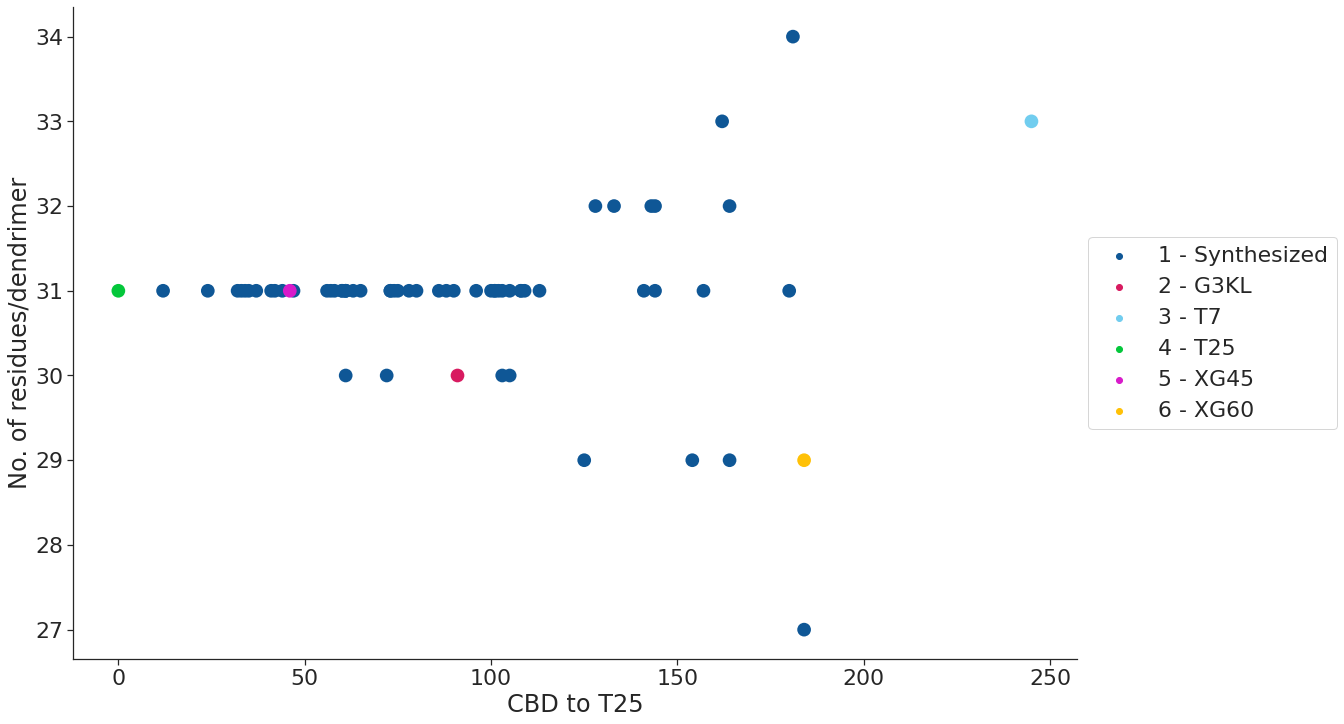

In [25]:
ax = sns.scatterplot(x='CBD', y='Length', data=df_scatter, palette=['#0F5796', '#D81B60', '#71CDEF', '#04C73B', '#D81BCA', '#FFC107'], hue='Set', marker='.', s=750, linewidth=0)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel='CBD to T25', ylabel='No. of residues/dendrimer')
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()

plt.savefig('plots/T25_length_scatter.pdf', bbox_inches='tight')

Number of Lysines (K) vs. CBD

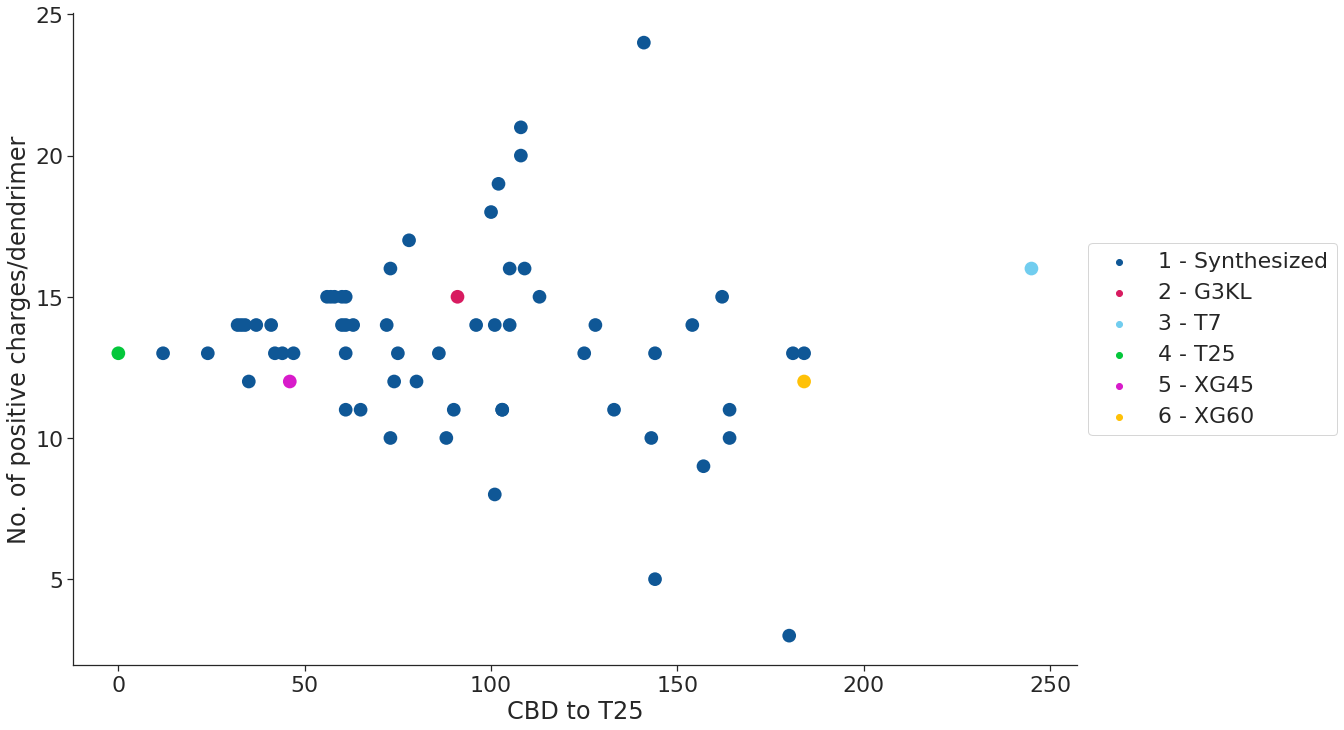

In [27]:
ax = sns.scatterplot(x='CBD', y='num_K', data=df_scatter, palette=['#0F5796', '#D81B60', '#71CDEF', '#04C73B', '#D81BCA', '#FFC107'], hue='Set', marker='.', s=750, linewidth=0)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel='CBD to T25', ylabel='No. of positive charges/dendrimer')
sns.set(font_scale = 2)
sns.set_style('ticks')
sns.despine()

plt.savefig('plots/T25_num_K_scatter.pdf', bbox_inches='tight')

Interactive PCA plot

In [42]:
f = Faerun(
    view="front", 
    coords=False,
    title="", 
    clear_color="#FFFFFF"
)

f.add_scatter(
    "T25_MXFP_PCA_2D",
    {
        "x": pca_mxfp_2D[:, 0],
        "y": pca_mxfp_2D[:, 1],
        "c": [set_data,
            df['MW'].values.tolist(), 
            df['num_K'].values.tolist(), 
            df['num_L'].values.tolist(), 
            df['frac_K'].values.tolist(), 
            df['frac_L'].values.tolist(), 
            df['CBD'].values.tolist(),
            df['NumVarPos'].values.tolist(),
            g0_data, 
            g1_data, 
            g2_data, 
            g3_data,
            ],
        "s": [size_list,
            size_list, 
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            ],
        "labels": df['seq'].values.tolist(),
    },
    shader="sphere",
    point_scale=2.0,
    max_point_size=20,
    legend_labels=[set_labels, None, None, None, None, None, None, None, g0_labels, g1_labels, g2_labels, g3_labels],
    categorical=[True, False, False, False, False, False, False, False, True, True, True, True],
    colormap=[seven_cmap, 'rainbow', 'rainbow', 'rainbow', 'rainbow', 'rainbow', 'rainbow_r', 'rainbow', five_cmap, five_cmap, five_cmap, five_cmap],
    series_title=['Set', 'ExactMolWt', 'num_K', 'num_L', 'frac_K', 'frac_L', 'CBD towards T25', 'num_VarPos', 'VarPos_G0', 'VarPos_G1','VarPos_G2', 'VarPos_G3'],
    has_legend=True,
)
f.plot('plots/T25_MXFP_PCA_2D')

/home/markus/Developer/Code/ChemicalSpace/T25_analogs/plots/T25_MXFP_PCA_2D.html

PCA 3D

In [29]:
pca_mxfp_3D = pca3D.fit_transform(mxfp)
pca3D.explained_variance_ratio_

array([0.71121053, 0.15715385, 0.04055254])

In [30]:
f = Faerun(
    view="free", 
    coords=False,
    title="", 
    clear_color="#FFFFFF"
)

f.add_scatter(
    "T25_MXFP_PCA_3D",
    {
        "x": pca_mxfp_3D[:, 0],
        "y": pca_mxfp_3D[:, 1],
        "z": pca_mxfp_3D[:, 2],
        "c": [set_data,
            df['MW'].values.tolist(), 
            df['num_K'].values.tolist(), 
            df['num_L'].values.tolist(), 
            df['frac_K'].values.tolist(), 
            df['frac_L'].values.tolist(), 
            df['CBD'].values.tolist(),
            df['NumVarPos'].values.tolist(),
            g0_data, 
            g1_data, 
            g2_data, 
            g3_data,
            ],
        "s": [size_list,
            size_list, 
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            ],
        "labels": df['seq'].values.tolist(),
    },
    shader="sphere",
    point_scale=2.0,
    max_point_size=20,
    legend_labels=[set_labels, None, None, None, None, None, None, None, g0_labels, g1_labels, g2_labels, g3_labels],
    categorical=[True, False, False, False, False, False, False, False, True, True, True, True],
    colormap=[seven_cmap, 'rainbow', 'rainbow', 'rainbow', 'rainbow', 'rainbow', 'rainbow', 'rainbow', five_cmap, five_cmap, five_cmap, five_cmap],
    series_title=['Set', 'ExactMolWt', 'num_K', 'num_L', 'frac_K', 'frac_L', 'CBD towards T25', 'num_VarPos', 'VarPos_G0', 'VarPos_G1','VarPos_G2', 'VarPos_G3'],
    has_legend=True,
)
f.plot('plots/T25_MXFP_PCA_3D')

/home/markus/Developer/Code/ChemicalSpace/T25_analogs/plots/T25_MXFP_PCA_3D.html

#### PCA with similarity mapplet approach

In [27]:
def CBD(a, b):
    return sum(abs(np.array(a)-np.array(b)))

def SimilarityMappletFingerprint(mxfp, mxfp_list):
    return [CBD(mxfp, fp) for fp in mxfp_list]

In [28]:
random_mxfp_selection = df.sample(n=100, random_state=42)
mxfp_list = random_mxfp_selection['MXFP']

df['RandomSimilarityMappletFingerprint'] = df.MXFP.progress_apply(lambda x: SimilarityMappletFingerprint(x, mxfp_list))
random_similarity_mapplet_fp = df['RandomSimilarityMappletFingerprint'].values.tolist()

100%|██████████| 50625/50625 [02:49<00:00, 298.71it/s]


PCA Similarity Mapplet 2D

In [29]:
pca_random_sm_2D = pca2D.fit_transform(random_similarity_mapplet_fp)
pca2D.explained_variance_ratio_

array([0.63631979, 0.30917131])

In [37]:
f = Faerun(
    view="front", 
    coords=False,
    title="", 
    clear_color="#FFFFFF"
)

f.add_scatter(
    "T25_MXFP_PCA_RandomSimilarityMapplet_2D",
    {
        "x": pca_random_sm_2D[:, 0],
        "y": pca_random_sm_2D[:, 1],
        "c": [set_data,
            df['MW'].values.tolist(), 
            df['num_K'].values.tolist(), 
            df['num_L'].values.tolist(), 
            df['frac_K'].values.tolist(), 
            df['frac_L'].values.tolist(), 
            df['CBD'].values.tolist(),
            df['NumVarPos'].values.tolist(),
            g0_data, 
            g1_data, 
            g2_data, 
            g3_data,
            ],
        "s": [size_list,
            size_list, 
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            ],
        "labels": df['seq'].values.tolist(),
    },
    shader="sphere",
    point_scale=2.0,
    max_point_size=20,
    legend_labels=[set_labels, None, None, None, None, None, None, None, g0_labels, g1_labels, g2_labels, g3_labels],
    categorical=[True, False, False, False, False, False, False, False, True, True, True, True],
    colormap=[eight_cmap, 'rainbow', 'rainbow', 'rainbow', 'rainbow', 'rainbow', 'rainbow', 'rainbow', five_cmap, five_cmap, five_cmap, five_cmap],
    series_title=['Set', 'ExactMolWt', 'num_K', 'num_L', 'frac_K', 'frac_L', 'CBD towards T25', 'num_VarPos', 'VarPos_G0', 'VarPos_G1','VarPos_G2', 'VarPos_G3'],
    has_legend=True,
)
f.plot('/home/markus/Developer/Data/chemical_space/T25_analogs/T25_MXFP_PCA_RandomSimilarityMapplet_2D')

NameError: name 'pca_random_sm_2D' is not defined

PCA Similarity Mapplet 3D

In [32]:
pca_random_sm_3D = pca3D.fit_transform(random_similarity_mapplet_fp)
pca3D.explained_variance_ratio_

array([0.63631979, 0.30917131, 0.02551149])

In [37]:
f = Faerun(
    view="free", 
    coords=False,
    title="", 
    clear_color="#FFFFFF"
)

f.add_scatter(
    "T25_MXFP_PCA_RandomSimilarityMapplet_3D",
    {
        "x": pca_random_sm_3D[:, 0],
        "y": pca_random_sm_3D[:, 1],
        "z": pca_random_sm_3D[:, 2],
        "c": [set_data,
            df['MW'].values.tolist(), 
            df['num_K'].values.tolist(), 
            df['num_L'].values.tolist(), 
            df['frac_K'].values.tolist(), 
            df['frac_L'].values.tolist(), 
            df['CBD'].values.tolist(),
            df['NumVarPos'].values.tolist(),
            g0_data, 
            g1_data, 
            g2_data, 
            g3_data,
            ],
        "s": [size_list,
            size_list, 
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            ],
        "labels": df['seq'].values.tolist(),
    },
    shader="sphere",
    point_scale=2.0,
    max_point_size=20,
    legend_labels=[set_labels, None, None, None, None, None, None, None, g0_labels, g1_labels, g2_labels, g3_labels],
    categorical=[True, False, False, False, False, False, False, False, True, True, True, True],
    colormap=[eight_cmap, 'rainbow', 'rainbow', 'rainbow', 'rainbow', 'rainbow', 'rainbow_r', 'rainbow', five_cmap, five_cmap, five_cmap, five_cmap],
    series_title=['Set', 'ExactMolWt', 'num_K', 'num_L', 'frac_K', 'frac_L', 'CBD towards T25', 'num_VarPos', 'VarPos_G0', 'VarPos_G1','VarPos_G2', 'VarPos_G3'],
    has_legend=True,
)
f.plot('/home/markus/Developer/Data/chemical_space/T25_analogs/T25_MXFP_PCA_RandomSimilarityMapplet_3D')

/home/markus/Developer/Data/chemical_space/T25_analogs/T25_MXFP_PCA_RandomSimilarityMapplet_3D.html

PCA Similarity Mapplet with synthesized compounds

In [35]:
df_2018 = df[df['Set'] == '1 - Synthesized in 2018']
df_2021 = df[df['Set'] == '2 - Synthesized in 2021']
df_2018_2021 = df[df['Set'] == '3 - Synthesized in 2018 & 2021']

df_synthesized = pd.concat([df_2018, df_2021, df_2018_2021])
synthesized_mxfp = df_synthesized.MXFP.values.tolist()

In [36]:
df['SynthesizedSimilarityMappletFingerprint'] = df.MXFP.progress_apply(lambda x: SimilarityMappletFingerprint(x, synthesized_mxfp))
synth_similarity_mapplet_fp = df['SynthesizedSimilarityMappletFingerprint'].values.tolist()

100%|██████████| 50625/50625 [02:29<00:00, 339.58it/s]


PCA 2D

In [38]:
pca_synthesized_sm_2D = pca2D.fit_transform(synth_similarity_mapplet_fp)
pca2D.explained_variance_ratio_

array([0.9380491 , 0.04696484])

In [39]:
f = Faerun(
    view="front", 
    coords=False,
    title="", 
    clear_color="#FFFFFF"
)

f.add_scatter(
    "T25_MXFP_PCA_SynthSimilarityMapplet",
    {
        "x": pca_synthesized_sm_2D[:, 0],
        "y": pca_synthesized_sm_2D[:, 1],
        "c": [set_data,
            df['MW'].values.tolist(), 
            df['num_K'].values.tolist(), 
            df['num_L'].values.tolist(), 
            df['frac_K'].values.tolist(), 
            df['frac_L'].values.tolist(), 
            df['CBD'].values.tolist(),
            df['NumVarPos'].values.tolist(),
            g0_data, 
            g1_data, 
            g2_data, 
            g3_data,
            ],
        "s": [size_list,
            size_list, 
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            ],
        "labels": df['seq'].values.tolist(),
    },
    shader="sphere",
    point_scale=2.0,
    max_point_size=20,
    legend_labels=[set_labels, None, None, None, None, None, None, None, g0_labels, g1_labels, g2_labels, g3_labels],
    categorical=[True, False, False, False, False, False, False, False, True, True, True, True],
    colormap=[eight_cmap, 'rainbow', 'rainbow', 'rainbow', 'rainbow', 'rainbow', 'rainbow_r', 'rainbow', five_cmap, five_cmap, five_cmap, five_cmap],
    series_title=['Set', 'ExactMolWt', 'num_K', 'num_L', 'frac_K', 'frac_L', 'CBD towards T25', 'num_VarPos', 'VarPos_G0', 'VarPos_G1','VarPos_G2', 'VarPos_G3'],
    has_legend=True,
)
f.plot('/home/markus/Developer/Data/chemical_space/T25_analogs/T25_MXFP_PCA_SynthesizedSimilarityMapplet_2D')

/home/markus/Developer/Data/chemical_space/T25_analogs/T25_MXFP_PCA_SynthesizedSimilarityMapplet_2D.html

PCA 3D

In [40]:
pca_sm_synth_3D = pca3D.fit_transform(synth_similarity_mapplet_fp)
pca3D.explained_variance_ratio_

array([0.9380491 , 0.04696484, 0.01053921])

In [41]:
f = Faerun(
    view="free", 
    coords=False,
    title="", 
    clear_color="#FFFFFF"
)

f.add_scatter(
    "T25_MXFP_PCA_SynthSimilarityMapplet_3D",
    {
        "x": pca_sm_synth_3D[:, 0],
        "y": pca_sm_synth_3D[:, 1],
        "z": pca_sm_synth_3D[:, 2],
        "c": [set_data,
            df['MW'].values.tolist(), 
            df['num_K'].values.tolist(), 
            df['num_L'].values.tolist(), 
            df['frac_K'].values.tolist(), 
            df['frac_L'].values.tolist(), 
            df['CBD'].values.tolist(),
            df['NumVarPos'].values.tolist(),
            g0_data, 
            g1_data, 
            g2_data, 
            g3_data,
            ],
        "s": [size_list,
            size_list, 
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            size_list,
            ],
        "labels": df['seq'].values.tolist(),
    },
    shader="sphere",
    point_scale=2.0,
    max_point_size=20,
    legend_labels=[set_labels, None, None, None, None, None, None, None, g0_labels, g1_labels, g2_labels, g3_labels],
    categorical=[True, False, False, False, False, False, False, False, True, True, True, True],
    colormap=[eight_cmap, 'rainbow', 'rainbow', 'rainbow', 'rainbow', 'rainbow', 'rainbow_r', 'rainbow', five_cmap, five_cmap, five_cmap, five_cmap],
    series_title=['Set', 'ExactMolWt', 'num_K', 'num_L', 'frac_K', 'frac_L', 'CBD towards T25', 'num_VarPos', 'VarPos_G0', 'VarPos_G1','VarPos_G2', 'VarPos_G3'],
    has_legend=True,
)
f.plot('/home/markus/Developer/Data/chemical_space/T25_analogs/T25_MXFP_PCA_SynthesizedSimilarityMapplet_3D')

/home/markus/Developer/Data/chemical_space/T25_analogs/T25_MXFP_PCA_SynthesizedSimilarityMapplet_3D.html